In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import mannwhitneyu


In [3]:
analysis_dir = Path("/n/home08/rcalef/sandbox/projects/txplm/canonical_evals/blast_k_sweep")

retrieval_metrics = (
    pd.read_table(analysis_dir / "retrieval_metrics.tsv")
    .assign(
        k=lambda x: x.model.str.split("_").str[-1],
    )
)
qa_metrics = (
    pd.read_table(analysis_dir / "qa_metrics.tsv")
    .assign(
        k=lambda x: x.model.str.split("_").str[-1],
    )
)

In [4]:
retrieval_metrics.head()

,model,dataset,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,...,precision_k100_ub,recall_k100_lb,recall_k100_ub,Fmax_lb,Fmax_ub,auroc_lb,auroc_ub,auprc_lb,auprc_ub,k
0,BlastKnn_k_1,protein_go_process_eval_pt_ft,0.151246,0.620061,0.128188,0.809039,0.097420,0.988423,0.317115,0.586368,...,0.097879,0.986721,0.989937,0.312516,0.321926,0.583676,0.589079,0.229979,0.239334,1
1,BlastKnn_k_1,protein_go_function_eval_pt_ft,0.223356,0.734896,0.150635,0.852888,0.097832,0.991682,0.554923,0.725602,...,0.098899,0.988651,0.993915,0.540931,0.568468,0.717568,0.733592,0.458833,0.488306,1
2,BlastKnn_k_1,protein_go_component_eval_pt_ft,0.180075,0.649429,0.132622,0.784247,0.098594,0.991994,0.421638,0.649977,...,0.099902,0.987669,0.995033,0.405558,0.438302,0.640516,0.659828,0.318883,0.353684,1
3,BlastKnn_k_1,protein_go_process_eval_five_shot,0.114673,0.065043,0.057710,0.065084,0.089709,0.616025,0.208009,0.532247,...,0.093489,0.589764,0.643243,0.202349,0.214283,0.529308,0.535508,0.142753,0.153784,1
4,BlastKnn_k_1,protein_go_function_eval_five_shot,0.116071,0.071819,0.058036,0.071819,0.094351,0.664908,0.207138,0.535544,...,0.102193,0.610097,0.715764,0.197274,0.220000,0.530331,0.541691,0.143780,0.164705,1


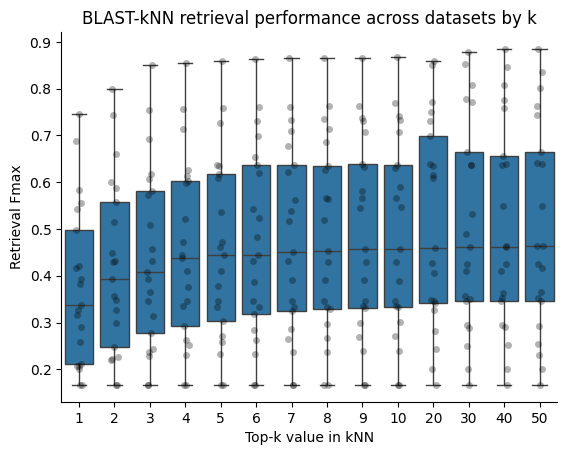

In [5]:
sns.boxplot(
    x="k",
    y="Fmax",
    data=retrieval_metrics,
)
sns.stripplot(
    x="k",
    y="Fmax",
    data=retrieval_metrics,
    color="black",
    alpha=0.3,
)
plt.ylabel("Retrieval Fmax")
plt.xlabel("Top-k value in kNN")
plt.title("BLAST-kNN retrieval performance across datasets by k")

sns.despine()

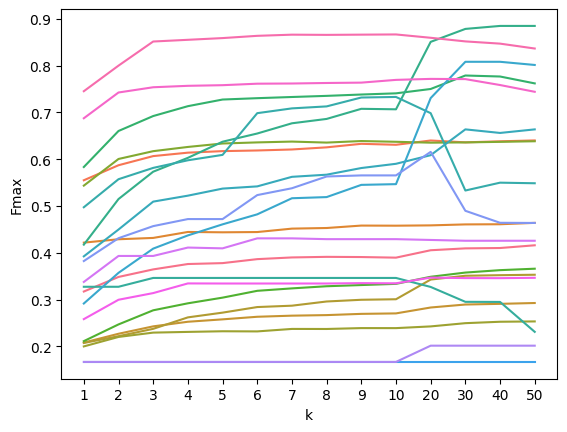

In [6]:
sns.lineplot(
    x="k",
    y="Fmax",
    hue="dataset",
    data=retrieval_metrics
)
plt.legend().remove()

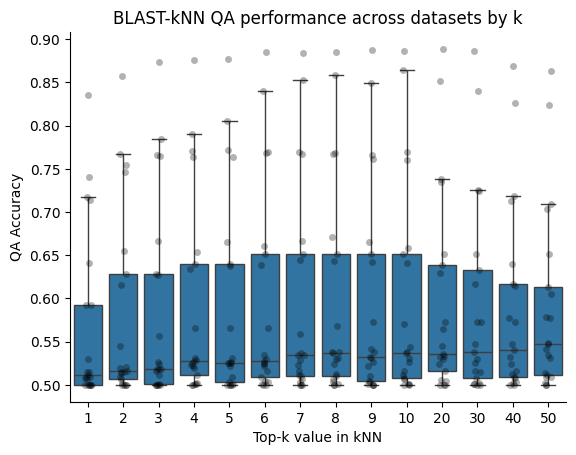

In [7]:
sns.boxplot(
    x="k",
    y="acc",
    data=qa_metrics,
    showfliers=False,
)

sns.stripplot(
    x="k",
    y="acc",
    data=qa_metrics,
    color="black",
    alpha=0.3,
)
plt.xlabel("Top-k value in kNN")
plt.title("BLAST-kNN QA performance across datasets by k")
plt.ylabel("QA Accuracy")

sns.despine()

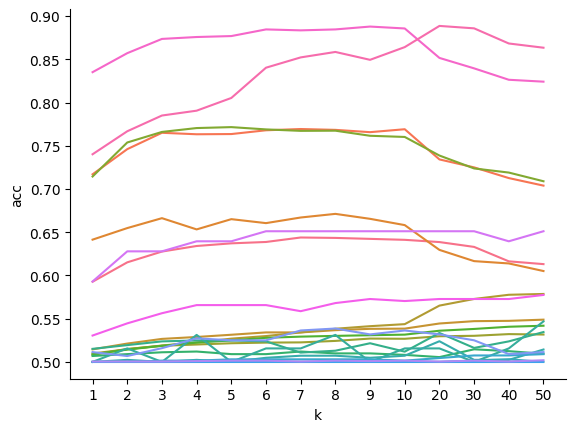

In [8]:
sns.lineplot(
    x="k",
    y="acc",
    hue="dataset",
    data=qa_metrics,
)
plt.legend().remove()
sns.despine()


In [9]:
pvals = []
for k1, k2 in combinations(retrieval_metrics.k.unique(), r=2):
    d1 = retrieval_metrics.query("k == @k1").Fmax
    d2 = retrieval_metrics.query("k == @k2").Fmax
    pval = mannwhitneyu(d1, d2).pvalue
    pvals.append({
        "k1": k1,
        "k2": k2,
        "pval": pval,
    })
pvals = pd.DataFrame(pvals)
pvals.sort_values("pval", ascending=True).head()

,k1,k2,pval
9,1,20,0.041555
11,1,40,0.062628
10,1,30,0.066259
12,1,50,0.070062
8,1,10,0.082484


In [10]:
len(pvals)

91

In [11]:
0.05 / 91

0.0005494505494505495

In [12]:
pvals = []
for k1, k2 in combinations(qa_metrics.k.unique(), r=2):
    d1 = qa_metrics.query("k == @k1").acc
    d2 = qa_metrics.query("k == @k2").acc
    pval = mannwhitneyu(d1, d2).pvalue
    pvals.append({
        "k1": k1,
        "k2": k2,
        "pval": pval,
    })
pvals = pd.DataFrame(pvals)
pvals.sort_values("pval", ascending=True).head()

,k1,k2,pval
9,1,20,0.177353
6,1,8,0.181455
12,1,50,0.194108
5,1,7,0.194108
8,1,10,0.207435
